In [67]:
import numpy as np
import random
from scipy.stats import norm

In [68]:
class MDP:
    def __init__(self, gamma, state_space, action_space, transition_function, reward_function, sample_transition_reward):
        self.gamma = gamma  # discount factor
        self.S = state_space  # state space
        self.A = action_space  # action space
        self.T = transition_function  # transition function: T(s, a) -> distribution over next states
        self.R = reward_function  # reward function: R(s, a, s') -> reward
        self.TR = sample_transition_reward  # function to sample (s', r) given (s, a)


In [69]:
def lookahead(P, U, s, a):
    S, T, R, gamma = P.S, P.T, P.R, P.gamma
    
    if callable(U):  # U es una función: U(s′)
        return R(s, a) + gamma * sum(T(s, a, s_prime) * U(s_prime) for s_prime in S)
    else:  # U es una lista o vector: U[i] con S indexado
        return R(s, a) + gamma * sum(T(s, a, s_prime) * U[i] for i, s_prime in enumerate(S))

def iterative_policy_evaluation(P, pi, k_max):
    S, T, R, gamma = P.S, P.T, P.R, P.gamma
    U = [0.0 for _ in S]
    
    for _ in range(k_max):
        U = [lookahead(P, U, s, pi(s)) for s in S]
    
    return U

def policy_evaluation(P, pi):
    S, R, T, gamma = P.S, P.R, P.T, P.gamma
    n = len(S)
    
    R_vec = np.array([R(s, pi(s)) for s in S])
    T_mat = np.array([[T(s, pi(s), s_prime) for s_prime in S] for s in S])
    
    I = np.eye(n)
    U = np.linalg.solve(I - gamma * T_mat, R_vec)
    
    return U

In [70]:
class ValueFunctionPolicy:
    def __init__(self, P, U):
        self.P = P  # MDP
        self.U = U  # utilidad, puede ser función o lista

    def __call__(self, s):
        return greedy(self.P, self.U, s)['a']


def greedy(P, U, s):
    best_action = None
    best_value = float("-inf")
    
    for a in P.A:
        value = lookahead(P, U, s, a)
        if value > best_value:
            best_value = value
            best_action = a
    
    return {"a": best_action, "u": best_value}


In [71]:
class PolicyIteration:
    def __init__(self, pi_init, k_max):
        self.pi = pi_init  # política inicial (función)
        self.k_max = k_max  # número máximo de iteraciones

    def solve(self, P):
        pis = [self.pi]
        S = P.S
        Us = []
        for _ in range(self.k_max):
            Us.append(policy_evaluation(P, pis[-1]))
            pi_new = ValueFunctionPolicy(P, Us[-1])
            
            if all(pis[-1](s) == pi_new(s) for s in S):
                break
            
            pis.append(pi_new)
        
        return pis, Us 


In [72]:
# Espacios
S = list(range(3))  
A = list(range(3))  

# Parámetros del problema
demanda_probs = {0: 0.4, 1: 0.4, 2: 0.2}
gamma = 0.8

In [73]:
def T(s, a, s_prime):
    total = 0.0
    for d, p_d in demanda_probs.items():
        s_next = s - min(s,d) - max(0,s-2-d) + a
        if s_next == s_prime:
            total += p_d
    return total

def R(s, a):
    reward = 0.0
    for d, p_d in demanda_probs.items():

        ventas_tanque = min(s, d)
        ventas_barco = max(0, s-2-d)
        costo_pedido = 1.6 * a
        costo_almacenamiento = 0.020 * max(0, (s-min(s,d)-max(0,s-2-d)))

        r = 2 * ventas_tanque + 0.7 * ventas_barco - costo_pedido - costo_almacenamiento
        reward += p_d * r

    return reward

def sample_transition_reward(s, a):
    d = random.choices([0, 1, 2], weights=[0.4, 0.4, 0.2])[0]
    s_prime = max(0, s - d) + a

    ventas_tanque = min(s, d)
    ventas_barco = max(0, d - s)
    costo_pedido = 0 * a
    costo_almacenamiento = 0 * max(0, s - d)
    r = 50 * ventas_tanque + 100 * ventas_barco - costo_pedido - costo_almacenamiento

    return s_prime, r

In [74]:
mdp = MDP(
    gamma=0.99,
    state_space=S,
    action_space=A,
    transition_function=T,
    reward_function=R,
    sample_transition_reward=sample_transition_reward
)

In [75]:
# Política inicial: siempre pide 1
initial_policy = lambda s: 1
solver = PolicyIteration(pi_init=initial_policy, k_max=100)
policys, Us = solver.solve(mdp)
print(Us)

for s in S:
    print(f"Stock: {s}, Acción óptima: {policys[-1](s)}")


[array([-3.11889891, -1.53424132, -0.54268176]), array([-0.        ,  1.97350993,  3.90316214]), array([21.60042068, 23.42898589, 25.05092998])]
Stock: 0, Acción óptima: 2
Stock: 1, Acción óptima: 1
Stock: 2, Acción óptima: 0


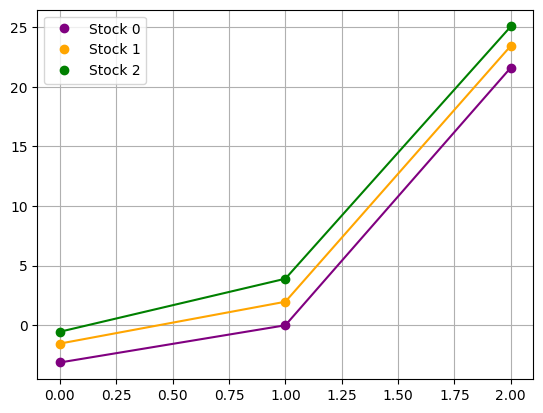

In [76]:
import matplotlib.pyplot as plt

U = []

for i in range(len(Us[0])):
    aux = []
    for j in range(len(Us)):
        aux.append(Us[j][i])
    U.append(aux)

fig, ax = plt.subplots(1,1)

ax.plot(U[0], 'o', color='purple', label='Stock 0')
ax.plot(U[0], color='purple')

ax.plot(U[1], 'o', color='orange', label='Stock 1')
ax.plot(U[1], color='orange')

ax.plot(U[2], 'o', color='green', label='Stock 2')
ax.plot(U[2], color='green')

ax.grid()
plt.legend()
plt.show()

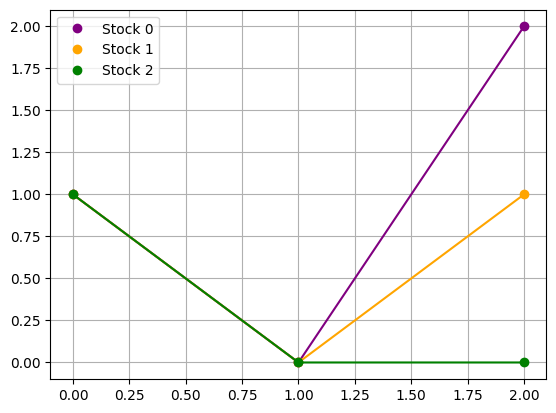

In [77]:
import matplotlib.pyplot as plt

U = []

for i in range(len(S)):
    aux = []
    for j in range(len(policys)):
        aux.append(policys[j](S[i]))
    U.append(aux)

fig, ax = plt.subplots(1,1)

ax.plot(U[0], 'o', color='purple', label='Stock 0')
ax.plot(U[0], color='purple')

ax.plot(U[1], 'o', color='orange', label='Stock 1')
ax.plot(U[1], color='orange')

ax.plot(U[2], 'o', color='green', label='Stock 2')
ax.plot(U[2], color='green')

ax.grid()
plt.legend()
plt.show()

In [78]:
def generar_diccionario(n, media, varianza):
    x = np.arange(n)
    valores = norm.pdf(x, loc=media, scale=np.sqrt(varianza))
    probabilidades = valores / valores.sum()
    return {i: round(probabilidades[i], 10) for i in range(n)}


In [83]:
# Espacios
S_amplified = list(range(5))  
A_amplified = list(range(5))  

# Parámetros del problema
#demanda_probs_amplified = generar_diccionario(100, 50, 200)`
demanda_probs_amplified = demanda_probs = {0: .01, 1: .01, 2: .01, 3:.01, 4:.96} 
gamma_amplified = 0.9

In [84]:
mdp = MDP(
    gamma=gamma_amplified,
    state_space=S_amplified,
    action_space=A_amplified,
    transition_function=T,
    reward_function=R,
    sample_transition_reward=sample_transition_reward
)

In [85]:
# Política inicial: siempre pide 1
initial_policy = lambda s: 1
solver = PolicyIteration(pi_init=initial_policy, k_max=100)
policys, Us = solver.solve(mdp)


In [86]:
for s in S_amplified:
    if policys[-1](s) != 0:
        print(f"Stock: {s}, Acción óptima: {policys[-1](s)}")

Stock: 0, Acción óptima: 4
Stock: 1, Acción óptima: 4
Stock: 2, Acción óptima: 4
Stock: 3, Acción óptima: 2
Stock: 4, Acción óptima: 2
